In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from data_pipeline import data_pipeline

plt.style.use('seaborn-v0_8')

In [8]:
data, _ = data_pipeline(top_features=None, plot=False, lags=27)

/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeinovich/anaconda3/envs/kaggle1/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [9]:
cols = ['bhp_I1_1d_ago',
        'bhp_I1_7d_ago',
        'bhp_I1_8d_ago',
        'bhp_I1_9d_ago',
        'bhp_I2_1d_ago',
        'bhp_I3_13d_ago',
        'bhp_I3_1d_ago',
        'bhp_I3_8d_ago',
        'bhp_I3_9d_ago',
        'coef',
        'liquid_1d_ago',
        'liquid_2d_ago',
        'liquid_3d_ago',
        'liquid_4d_ago',
        'liquid_5d_ago',
        'liquid_6d_ago',
        'liquid_base_1d_ago',
        'liquid_base_2d_ago',
        'liquid_base_3d_ago',
        'liquid_base_4d_ago',
        'liquid_base_5d_ago',
        'oil_1d_ago',
        'oil_2d_ago',
        'oil_3d_ago',
        'oil_5d_ago',
        'oil_base',
        'oil_base_2d_ago',
        'oil_base_3d_ago',
        'oil_base_4d_ago',
        'oil_base_5d_ago',
        'start_lag',
        'status_I3',
        'status_I3_13d_ago',
        'status_I3_7d_ago',
        'status_I3_8d_ago',
        'status_I3_9d_ago',
        'water_1d_ago',
        'water_4d_ago',
        'water_I3_13d_ago',
        'water_I3_1d_ago',
        'water_I3_2d_ago',
        'water_I3_8d_ago',
        'water_I3_9d_ago',
        'water_base']

In [17]:
def train_fn(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    for days_past, day in enumerate(test.date.unique()):
        for col in test.columns:
            for past in range(days_past + 1):
                if f'{past}d_ago' in col:
                    test.loc[test.date == day, col] = -1

    if cols is None:
        cols = data.columns.tolist()
        for col in ['oil', 'water', 'liquid', 'delta_baseline']:
            cols.remove(col)
    
    model.fit(X=train[cols], y=train.delta_baseline)
    
    afterI3 = test[test.status_I3 == 1]
    y_pred = model.predict(afterI3[cols])
    return np.abs((afterI3.delta_baseline - y_pred) / afterI3.oil * 100)

def train_model(data, model, cols, stride=1):    
    mapes = [train_fn(data, model, i, cols) for i in range(1, 27, stride)]
    return np.hstack(mapes)

def plot_mape(mapes):
    plt.figure(figsize=(10, 5))
    plt.hist(mapes, bins=100)
    q95 = np.quantile(mapes, 0.95)
    plt.title(f'Error disstribution\n{q95 = :.2f}%')
    plt.axvline(q95, color='red', linestyle='--', label='95% quantile')
    plt.xlabel('MAPE')
    plt.ylabel('Count')
    plt.legend()
    plt.show()  


In [11]:
rf_params = {'n_estimators': 300, 
             'max_depth': 10, 
             'min_samples_split': 5, 
             'min_samples_leaf': 2, 
             'max_features': None,
             'n_jobs': 2,
             'random_state': 42}

rf = RandomForestRegressor(**rf_params)

mapes = train_model(data, rf, cols, stride=1)

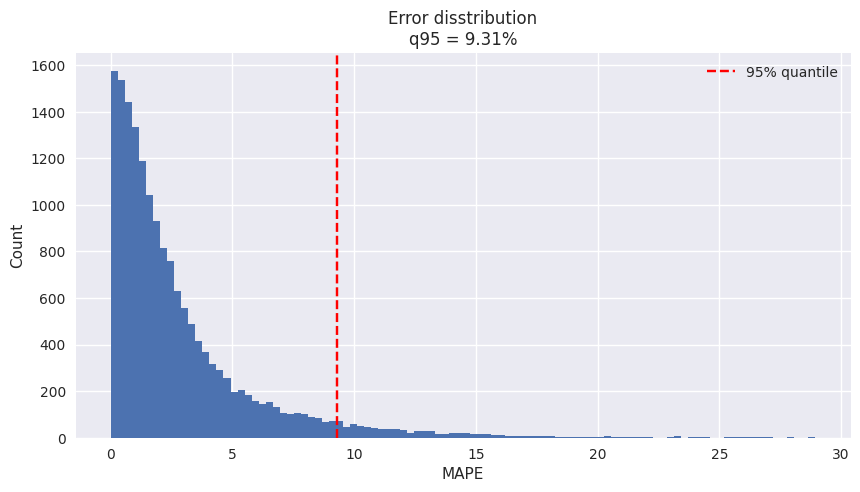

In [18]:
plot_mape(mapes)

In [19]:
pd.DataFrame(mapes).describe()

,0
count,16688.000000
mean,2.837284
std,3.185794
min,0.000111
25%,0.785085
50%,1.804259
75%,3.632158
max,28.937336


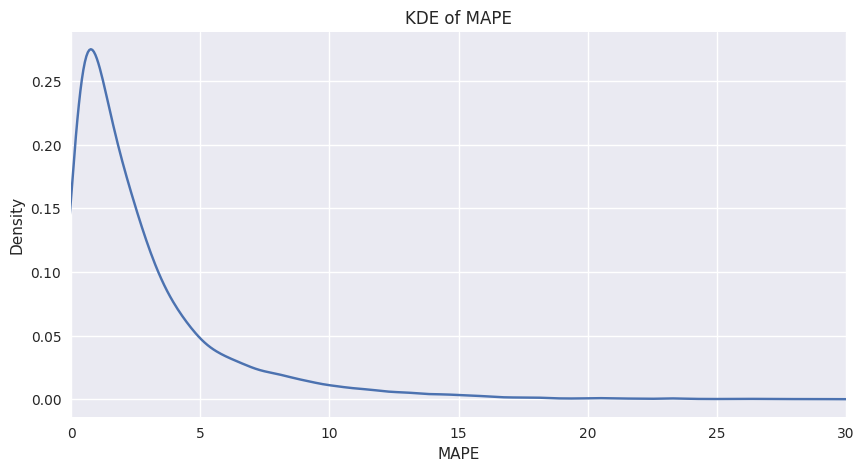

In [23]:
mapes_df = pd.DataFrame(mapes, columns=['mape'])

#plot kde of mapes
plt.figure(figsize=(10, 5))
plt.title('KDE of MAPE')
plt.xlabel('MAPE')
plt.ylabel('Density')
plt.xlim(0, 30)
mapes_df.mape.plot.kde()
plt.show()

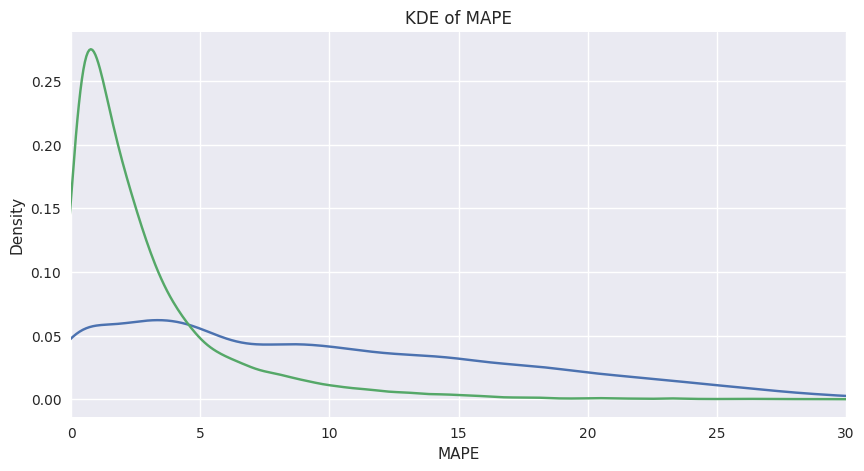

In [56]:
baseline_mapes = pd.read_csv('../data/1905-zeinovich-baseline.csv')

#plot kde of mapes
plt.figure(figsize=(10, 5))
plt.title('KDE of MAPE')
plt.xlabel('MAPE')
plt.ylabel('Density')
plt.xlim(0, 30)
baseline_mapes.mape.plot.kde()
mapes_df.mape.plot.kde()
plt.show()

In [65]:
mapes.shape

(16688,)

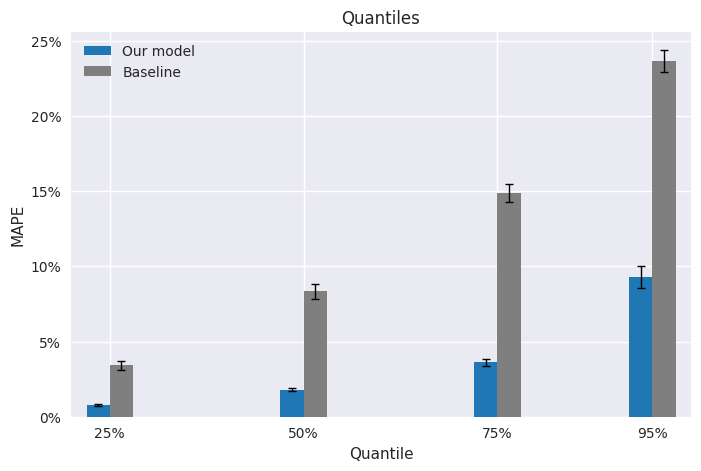

In [97]:
# bootstrap confidence interval for quantiles
def bootstrap(data, n_samples=4000, n_iters=500, quantile=0.95):
    sample = np.random.choice(data, size=(n_samples, n_iters), replace=True)
    return np.quantile(sample, quantile, axis=1)

plt.figure(figsize=(8, 5))

for q in [0.25, 0.5, 0.75, 0.95]:
    plt.bar(x=q-0.015, height=bootstrap(mapes, quantile=q).mean(),
            yerr=bootstrap(mapes, quantile=q).std(), width=0.03, color='tab:blue', 
            capsize=3, error_kw={'capthick': 1, 'elinewidth': 1})
    
    plt.bar(x=q+0.015, height=bootstrap(baseline_mapes.mape, quantile=q).mean(),
            yerr=bootstrap(baseline_mapes.mape, quantile=q).std(), width=0.03, color='tab:grey', 
            capsize=3, error_kw={'capthick': 1, 'elinewidth': 1})
    

plt.title('Quantiles')
plt.xlabel('Quantile')
plt.ylabel('MAPE')

plt.xticks([0.25, 0.5, 0.75, 0.95], ['25%', '50%', '75%', '95%'])
plt.yticks([0, 5, 10, 15, 20, 25], ['0%', '5%', '10%', '15%', '20%', '25%'])
plt.xlim(0.2, 1)
plt.legend(['Our model', 'Baseline'])
plt.show()